In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

#height of selected area of image to be processed
selected_area_height = 340

In [16]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    image_x = image.shape[0]
    image_y = image.shape[1]
    
    ### get hough lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((image_x, image_y, 3), dtype=np.uint8)
    
    ### calculate weighted mean of left and right lines
    ### where weights are line lengths, as longer the line, more probably it is a lane line
    left_a, left_b, right_a, right_b = [], [], [], []
    left_weights, right_weights = [], []
    for i in range(lines.shape[0]):
        line = lines[i][0]
        line_length = math.sqrt(math.pow(line[2]-line[0], 2) + math.pow(line[3]-line[1], 2))
        
        ### if line_length <= 0 then there is an error so skip
        if line_length <= 0:
            continue
            
        ### calculate slope of the line to get the direction
        ### which tells which lane line is it
        ### plus check if it is not on the wrong side, because that would be some dirt
        a = (line[1]-line[3])/(line[0]-line[2])
        if a > 0:
            if line[0] < image_y/2 or line[2] < image_y/2:
                continue
            left_a.append(a);
            left_b.append(line[1]-(a*line[0]))
            left_weights.append(line_length)
        else:
            if line[0] > image_y/2 or line[2] > image_y/2:
                continue
            right_a.append(a);
            right_b.append(line[1]-(a*line[0]))
            right_weights.append(line_length)
    
    ### calculate edge points for (weighted) mean lines
    lane_lines = np.zeros((2, 1, 4))
    if (len(left_a) > 0):
        left_a, left_b = np.average(left_a, weights=left_weights), np.average(left_b, weights=left_weights)
        lane_lines[0][0] = [(image_x-left_b)/left_a, image_x, (selected_area_height-left_b)/left_a, selected_area_height]
    if (len(right_a) > 0):
        right_a, right_b = np.average(right_a, weights=right_weights), np.average(right_b, weights=right_weights)
        lane_lines[1][0] = [(image_x-right_b)/right_a, image_x, (selected_area_height-right_b)/right_a, selected_area_height]

    draw_lines(line_img, lane_lines.astype(int))
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [17]:
def process_image(image):
    gray = grayscale(image)

    kernel_size = 3
    blurred = gaussian_blur(gray, kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges = canny(blurred, low_threshold, high_threshold)

    imshape = image.shape
    a = (130,imshape[0])
    b = ((imshape[1]/2)-70, selected_area_height)
    c = ((imshape[1]/2)+60, selected_area_height)
    d = (imshape[1]-40,imshape[0])
    vertices = np.array([[a, b, c, d]], dtype=np.int32)
    selected = region_of_interest(edges, vertices)

    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 100 #3    # maximum gap in pixels between connectable line segments
    hough = hough_lines(selected, rho, theta, threshold, min_line_length, max_line_gap)

    weighted = weighted_img(hough, image, 0.8, 0.5, 0)
    return weighted

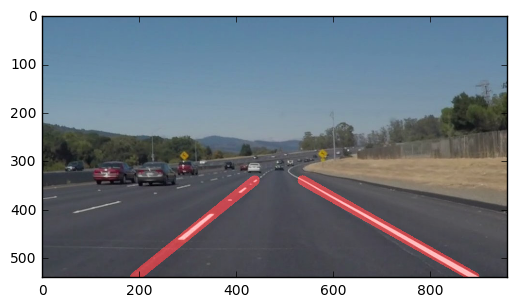

In [18]:
#test on single image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = process_image(image)

plt.imshow(image, cmap = "gray")

In [19]:
import os
images = os.listdir("test_images/")

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 16.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 9.59 s


In [21]:
white_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:25<00:00, 26.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 26.9 s


Reflection:
